In [1]:
import sys
print(sys.version)
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft2, ifft2
from scipy.integrate import solve_ivp
from scipy.sparse import spdiags

tspan = np.arange(0, 4 +0.5, 0.5)
nu = 0.001
Lx, Ly = 20, 20
nx, ny = 64, 64
N = nx * ny

x2 = np.linspace(-Lx/2, Lx/2, nx + 1)
x = x2[:nx]
y2 = np.linspace(-Ly/2, Ly/2, ny + 1)
y = y2[:ny]
X, Y = np.meshgrid(x, y)
w = 1 * np.exp(-X**2-Y**2/20)
w2=w.reshape(N)

kx = (2 * np.pi / Lx) * np.concatenate((np.arange(0, nx/2), np.arange(-nx/2, 0)))
kx[0] = 1e-6
ky = (2 * np.pi / Ly) * np.concatenate((np.arange(0, ny/2), np.arange(-ny/2, 0)))
ky[0] = 1e-6
KX, KY = np.meshgrid(kx, ky)
K = KX**2 + KY**2


m = 64 
n = m * m
dx=20/m

e0 = np.zeros((n, 1)) 
e1 = np.ones((n, 1))
e2 = np.copy(e1) 
e4 = np.copy(e0)

for j in range(1, m+1):
    e2[m*j-1] = 0
    e4[m*j-1] = 1  

e3 = np.zeros_like(e2)
e3[1:n] = e2[0:n-1]
e3[0] = e2[n-1]

e5 = np.zeros_like(e4)
e5[1:n] = e4[0:n-1]
e5[0] = e4[n-1]

diagonals = [e1.flatten(), e1.flatten(), e5.flatten(), 
             e2.flatten(), -4 * e1.flatten(), e3.flatten(), 
             e4.flatten(), e1.flatten(), e1.flatten()]
offsets = [-(n-m), -m, -m+1, -1, 0, 1, m-1, m, (n-m)]

matA = (spdiags(diagonals, offsets, n, n).toarray())/(dx**2)
A=matA
A[0,0]=2/dx**2

e1 = np.ones((n, 1))   
diagonals_B = [e1.flatten(), -e1.flatten(),e1.flatten(), -e1.flatten()]
offsets_B = [-(n-m), -m, m, (n-m)]
matB = (spdiags(diagonals_B, offsets_B, n, n).toarray())/(2*dx)
B=matB

e1 = np.zeros((n, 1))
for i in range(0, n, m):
    e1[i] = 1

e2 = np.ones((n, 1))
for i in range(m - 1, n, m):
    e2[i] = 0

e3 = np.ones((n, 1))
for i in range(0, n, m):
    e3[i] = 0

e4 = np.zeros((n, 1))
for i in range(m - 1, n, m):
    e4[i] = 1

diagonals_C = [e1.flatten(), -e2.flatten(), e3.flatten(), -e4.flatten()]
offsets_C = [-m+1,-1,1,m-1]

matC = (spdiags(diagonals_C, offsets_C, n, n).toarray())/(2*dx)
C=matC


def spc(t,w2, nx, ny, N, A, B, C, K, nu):
    w=w2.reshape((nx,ny))
    wt = fft2(w)
    psit = -wt / K
    psi=np.real(ifft2(psit)).reshape(N)
    rhs=nu*np.dot(A,w2)+(np.dot(B,w2))*(np.dot(C,psi))-(np.dot(B,psi))*(np.dot(C,w2))
    return rhs

wsol = solve_ivp(spc, [0, 4], w2, t_eval=tspan, args=(nx, ny, N,A, B, C, K, nu), method='RK45')
A1=wsol.y
print("A1",A1)

def GE(t,w2, nx, ny, N, A, B, C, K, nu):
    psi= np.linalg.solve(A,w2)
    rhs=nu*np.dot(A,w2)+(np.dot(B,w2))*(np.dot(C,psi))-(np.dot(B,psi))*(np.dot(C,w2))
    return rhs

wsol = solve_ivp(GE, [0, 4], w2, t_eval=tspan, args=(nx, ny, N, A, B, C, K, nu), method='RK45')
A2=wsol.y
print("A2",A2)

from scipy.linalg import lu,solve_triangular
P,L,U=lu(A)

def LU_rhs(t,w2, nx, ny, N, A, B, C, K,nu):
    Pb=np.dot(P,w2)
    y=solve_triangular(L,Pb,lower=True)
    psi=solve_triangular(U,y)
    rhs=nu*np.dot(A,w2)+(np.dot(B,w2))*(np.dot(C,psi))-(np.dot(B,psi))*(np.dot(C,w2))
    return rhs

wsol = solve_ivp(LU_rhs, [0, 4], w2, t_eval=tspan, args=(nx, ny, N, A, B, C, K, nu), method='RK45')
A3=wsol.y
print("A3",A3)

3.9.13 (main, Aug 25 2022, 18:29:29) 
[Clang 12.0.0 ]
A1 [[2.50656748e-46 3.59343426e-45 1.89141923e-44 ... 1.90792904e-42
  4.82195572e-42 1.14719429e-41]
 [1.17762859e-43 6.53684735e-43 2.62060754e-42 ... 1.58866557e-40
  3.55916152e-40 7.45533788e-40]
 [4.55107657e-41 1.93087628e-40 6.43663355e-40 ... 2.48966551e-38
  5.07459635e-38 9.69185374e-38]
 ...
 [1.96785570e-38 1.23636238e-37 5.46906656e-37 ... 4.35977114e-35
  1.02335874e-34 2.22858322e-34]
 [6.19028421e-41 5.34124949e-40 2.93882031e-39 ... 3.68664229e-37
  9.45501433e-37 2.23512843e-36]
 [1.60178709e-43 1.99879166e-42 1.41268009e-41 ... 2.80496038e-39
  7.96285822e-39 2.07493092e-38]]
A2 [[ 2.50656748e-46 -1.78630705e-36  1.02614869e-36 ... -5.75086257e-26
  -6.68013806e-25  3.02201851e-24]
 [ 1.17762859e-43 -2.26093387e-29  1.85614646e-29 ... -1.48306461e-19
  -7.82424220e-19  1.67449651e-18]
 [ 4.55107657e-41 -4.24661881e-29  3.48720993e-29 ... -2.20165937e-20
  -2.91637720e-19  1.23961335e-18]
 ...
 [ 1.96785570e-38  7

In [12]:
#opposite 
pos = 1.0; neg = -1.0
x01, y01 = -5, 0
x02, y02 = 5, 0
w3 = pos * np.exp(-(X+5)**2-Y**2/20) + neg*np.exp(-(X-5)**2-Y**2/20)
w4 = w3.reshape(N)
wsol = solve_ivp(LU_rhs, [0, 4], w4, t_eval=tspan, args=(nx, ny, N, A, B, C, K, nu), method='RK45')
oppo = wsol.y

#Same
w_same = np.exp(-((X + 5)**2 + Y**2)) + np.exp(-((X - 5)**2 + Y**2))
w_same = w_same.reshape(N)
wsol = solve_ivp(LU_rhs, [0, 4], w_same, t_eval=tspan, args=(nx, ny, N, A, B, C, K, nu), method='RK45')
same_sol = wsol.y

#colliding pair
w_colliding = (np.exp(-((X + 5)**2 + (Y + 5)**2)) - np.exp(-((X - 5)**2 + (Y - 5)**2)) +
             np.exp(-((X + 5)**2 + (Y - 5)**2)) - np.exp(-((X - 5)**2 + (Y + 5)**2)))
w_colliding = w_colliding.reshape(N)
wsol = solve_ivp(LU_rhs, [0, 4], w_colliding, t_eval=tspan, args=(nx, ny, N, A, B, C, K, nu), method='RK45')
pair_sol = wsol.y

#random
np.random.seed(42)

amplitude = np.random.uniform(-1, 1)
x0, y0 = np.random.uniform(-Lx / 2, Lx / 2), np.random.uniform(-Ly / 2, Ly / 2)
sigma_x, sigma_y = np.random.uniform(1, 3), np.random.uniform(1, 3)
w_random = amplitude * np.exp(-((X - x0)**2 / sigma_x**2 + (Y - y0)**2 / sigma_y**2))
w_random = w_random.reshape(N)
wsol = solve_ivp(LU_rhs, [0, 4], w_random, t_eval=tspan, args=(nx, ny, N, A, B, C, K, nu), method='RK45')
random_sol = wsol.y

MovieWriter imagemagick unavailable; using Pillow instead.


Elapsed time for opposite_gaussians: 1.27 seconds
Solution for opposite_gaussians:[[-1.38879439e-11 -1.91717259e-11 -2.70963304e-11 ... -1.05428248e-10
  -1.46015514e-10 -2.01465209e-10]
 [-2.56818763e-11 -3.46840049e-11 -4.83266267e-11 ... -1.85084844e-10
  -2.56449595e-10 -3.54221676e-10]
 [-4.56150426e-11 -6.11836833e-11 -8.45748343e-11 ... -3.13640186e-10
  -4.30962845e-10 -5.90205756e-10]
 ...
 [ 4.56150426e-11  3.76451600e-11  3.52449874e-11 ...  8.78513605e-11
   1.23239329e-10  1.72838623e-10]
 [ 2.56818763e-11  2.11318399e-11  1.98493101e-11 ...  5.16566074e-11
   7.31064199e-11  1.03361806e-10]
 [ 1.38879439e-11  1.13238687e-11  1.05745672e-11 ...  2.72962240e-11
   3.85227240e-11  5.42968874e-11]]


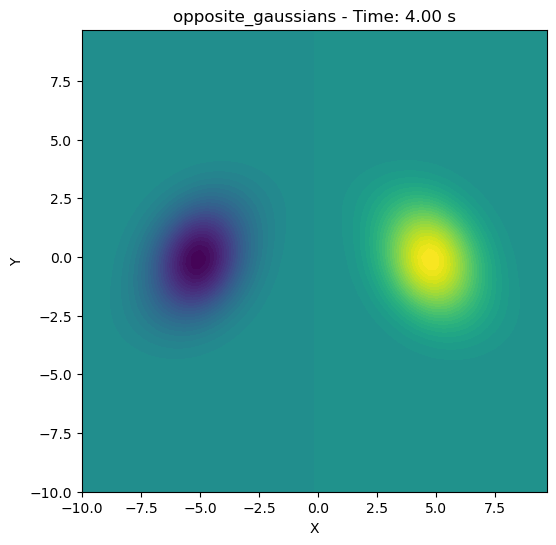

MovieWriter imagemagick unavailable; using Pillow instead.


Elapsed time for same_gaussians: 13.16 seconds
Solution for same_gaussians:[[ 1.38879439e-11  1.09189118e-09 -2.00684077e-09 ... -2.37998440e-09
   3.91353985e-09  3.42531155e-09]
 [ 2.56818763e-11  2.51560023e-05  1.33199121e-04 ...  3.46734534e-04
  -1.01202208e-03 -2.49833880e-03]
 [ 4.56150426e-11 -1.10684757e-07  8.00463185e-08 ...  1.24790030e-06
   6.84899574e-07 -4.86648886e-07]
 ...
 [ 4.56150426e-11 -1.46324542e-07 -2.33035871e-06 ...  1.49470241e-05
   1.79825239e-05  1.34540001e-05]
 [ 2.56818763e-11  1.99914176e-06  1.11529674e-05 ...  3.18595439e-05
  -9.47764696e-05 -2.31485501e-04]
 [ 1.38879439e-11  1.22756661e-05  1.79328603e-04 ... -1.20810263e-03
  -1.39953923e-03 -1.00610130e-03]]


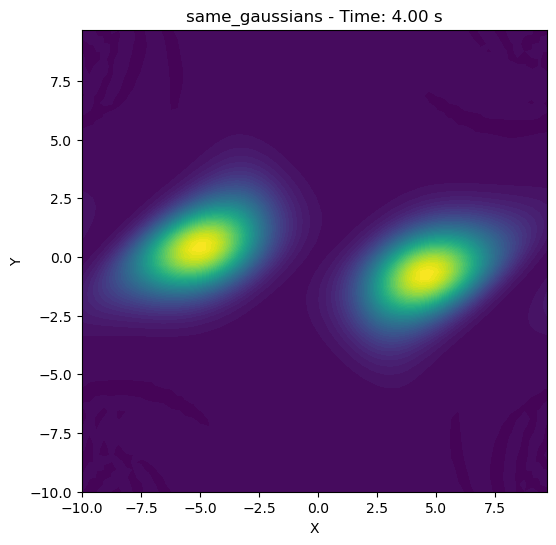

MovieWriter imagemagick unavailable; using Pillow instead.


Elapsed time for colliding_pairs: 1.36 seconds
Solution for colliding_pairs:[[-0.00482795 -0.00934443 -0.01709016 ... -0.06128624 -0.0588323
  -0.05164417]
 [-0.0072493  -0.01381425 -0.02541281 ... -0.09529298 -0.09331953
  -0.08228706]
 [-0.01052544 -0.01965044 -0.0353623  ... -0.1294807  -0.13241598
  -0.12381859]
 ...
 [ 0.01052544  0.01218134  0.02469854 ...  0.11568043  0.133385
   0.1274618 ]
 [ 0.0072493   0.00852519  0.01775144 ...  0.08655229  0.09723779
   0.08757355]
 [ 0.00482795  0.00565995  0.01176405 ...  0.05475069  0.0608526
   0.05385167]]


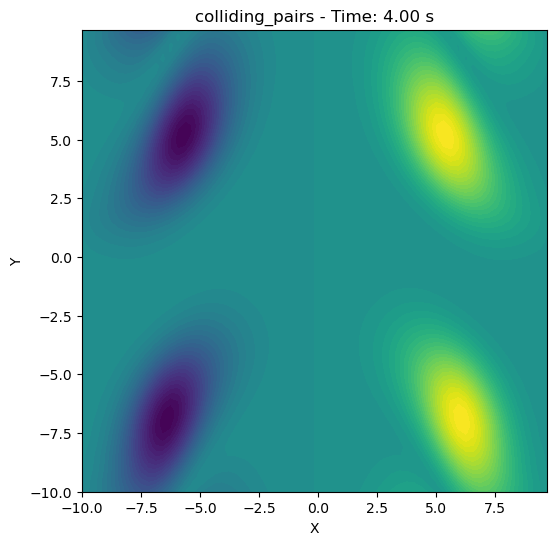

MovieWriter imagemagick unavailable; using Pillow instead.


Elapsed time for random_vortices: 15.04 seconds
Solution for random_vortices:[[-8.45532427e-01 -1.05639738e+00 -8.96080198e-01 ... -1.23473902e+00
  -1.09644654e+00 -1.24011747e+00]
 [-7.93691655e-01 -1.28200991e+00 -2.27952160e+00 ... -6.05226579e-01
  -1.01478446e+00  3.20230633e-01]
 [-6.90763867e-01 -4.35954766e-01 -5.33128297e-01 ... -1.23478546e+00
   3.54245373e-02 -1.02422795e+00]
 ...
 [-1.29765829e-10  6.01918650e-01 -1.23974917e+00 ... -8.12745431e-01
   4.73976867e-01  4.59983363e-01]
 [-1.32106962e-10 -9.51978733e-01  6.70734548e-01 ...  5.57624464e-01
  -2.29487856e-01  1.83722486e-01]
 [-1.29176528e-10 -2.72683955e-01 -1.44903971e-01 ...  9.28013357e-01
   5.93915563e-01  9.32109738e-01]]


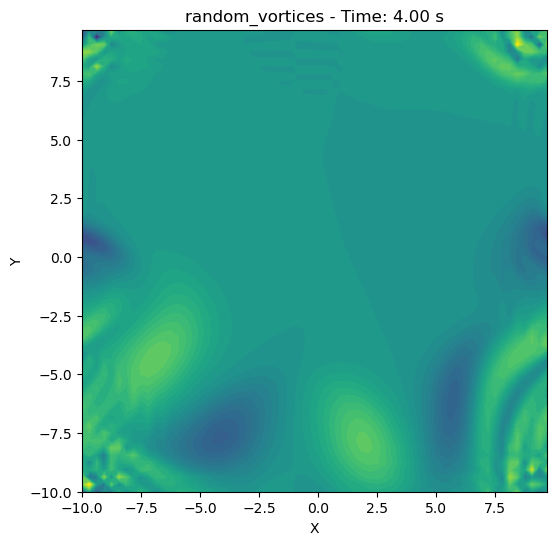

In [17]:
from time import time_ns
import time
from scipy.linalg import lu,solve_triangular
import matplotlib.animation as animation
def generate_vorticity_scenario(nx, ny, Lx, Ly, scenario, num_vortices=10):
    X, Y = np.meshgrid(np.linspace(-Lx/2, Lx/2, nx), np.linspace(-Ly/2, Ly/2, ny))
    if scenario == "opposite_gaussians":
        omega = np.exp(-((X - 5)**2 + Y**2) / 5) - np.exp(-((X + 5)**2 + Y**2) / 5)
    elif scenario == "same_gaussians":
        omega = np.exp(-((X - 5)**2 + Y**2) / 5) + np.exp(-((X + 5)**2 + Y**2) / 5)
    elif scenario == "colliding_pairs":
        omega = (np.exp(-((X - 6)**2 + (Y - 6)**2) / 6) - np.exp(-((X + 6)**2 + (Y - 6)**2) / 6) +
                 np.exp(-((X - 6)**2 + (Y + 6)**2) / 6) - np.exp(-((X + 6)**2 + (Y + 6)**2) / 6))
    elif scenario == "random_vortices":
        omega = np.zeros_like(X)
        for _ in range(num_vortices):
            x0 = np.random.uniform(-Lx/2, Lx/2)
            y0 = np.random.uniform(-Ly/2, Ly/2)
            strength = np.random.choice([-1, 1])
            omega += strength * np.exp(-((X - x0)**2 + (Y - y0)**2) / 5)
    else:
        raise ValueError("Unknown scenario type.")
    return omega.reshape(nx * ny)

def solve_with_lu_and_movie(vorticity_init, scenario_name):
    start_time = time.time()
    wtsol = solve_ivp(LU_rhs, [0, 4], vorticity_init, t_eval=tspan, args=(nx, ny, N, A, B, C, K, nu), method='RK45')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Elapsed time for {scenario_name}: {elapsed_time:.2f} seconds")
    print(f"Solution for {scenario_name}:{wtsol.y}")

    # Create a movie of the dynamics
    fig, ax = plt.subplots(figsize=(6, 6))
    def update_plot(i):
        ax.clear()
        state = wtsol.y[:, i].reshape((nx, ny))
        contour = ax.contourf(X, Y, state, levels=50, cmap='viridis')
        ax.set_title(f"{scenario_name} - Time: {tspan[i]:.2f} s")
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        return contour

    ani = animation.FuncAnimation(fig, update_plot, frames=len(tspan), blit=False, repeat=False)
    ani.save(f'vortex_dynamics_{scenario_name}.gif', writer='imagemagick', fps=10)
    plt.show()

scenarios = ["opposite_gaussians", "same_gaussians", "colliding_pairs", "random_vortices"]
for scenario in scenarios:
    omega_flat = generate_vorticity_scenario(nx, ny, Lx, Ly, scenario)
    solve_with_lu_and_movie(omega_flat, scenario)